In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
from astropy.io import ascii
from astropy.table import Table
from tqdm import tqdm
from astropy.convolution import convolve, Gaussian1DKernel, Box1DKernel
import numpy.ma as ma
from sqlalchemy import text
import pandas as pd
import matplotlib.pylab as pl
import matplotlib as mpl
import matplotlib.ticker as mticker
from scipy import stats
import pickle


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
loc = '/Users/allybaldelli/Desktop/AMNH-stuff/Doublet-Quantifiers'
sys.path.append(os.path.abspath(loc))

# Importing scripts needed
from Doublet_Quantifiers.curvefit import *
from Doublet_Quantifiers.models import *

mypath = '/Users/allybaldelli/Desktop/AMNH-stuff/quantifying_clouds_ally'
sys.path.append(os.path.abspath(mypath))

from functions.data_tools import *
from functions.visualizing_sonora_tools import *

In [3]:

# opening convolved data dictionary 
with open(mypath + "/diamondback-data/pickle_files/convolved_data/t1500_convolve_data_dict.pkl", "rb") as f:
    convolve_data_dict = pickle.load(f)

# opening pseudo-voigt parameter DataFrame
with open(mypath + "/diamondback-data/pickle_files/parameters/t1500_parameter_df.pkl", "rb") as f:
    parameter_df = pickle.load(f)



## Plotting

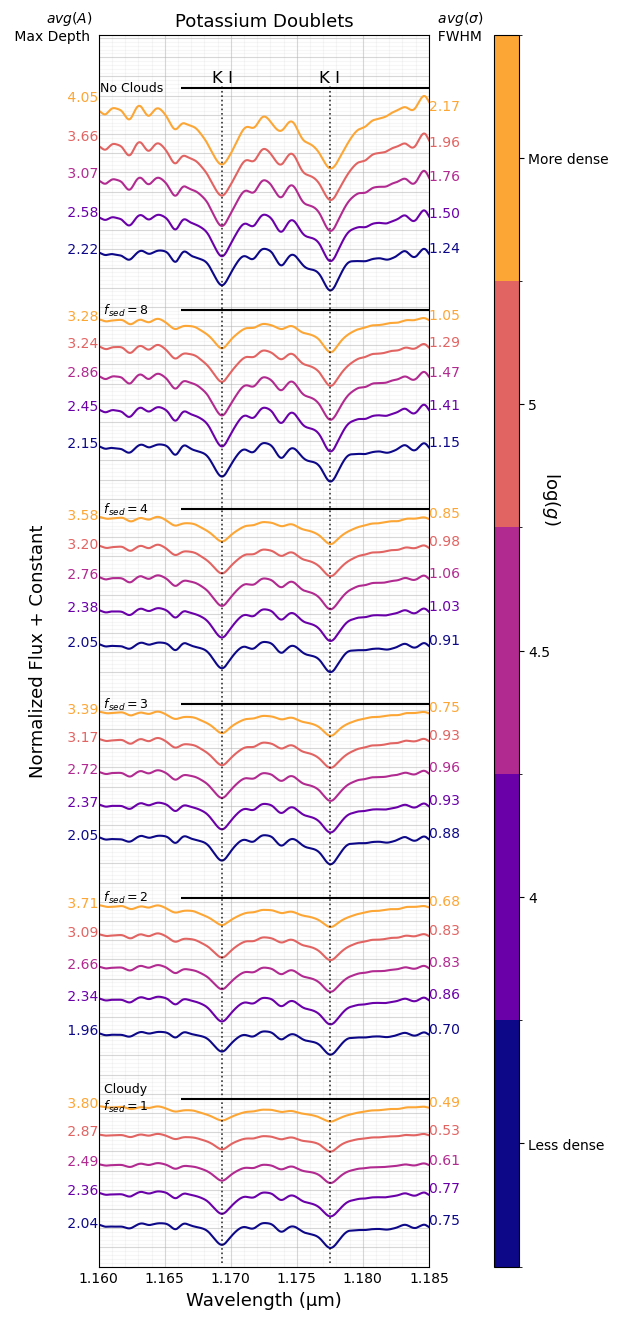

In [4]:
long_plot(parameter_df, convolve_data_dict, x_min = 1.16, x_max = 1.185, 
                  x_increment = 0.005, const_spacing = 1.6, norm_scaling = 7e10,
                  title = "Potassium Doublets", color_by_logg = True)
plt.savefig('/Users/allybaldelli/Desktop/AMNH-stuff/quantifying_clouds_ally/plots/long_plot_logg.png')